# Avaliação BlueScore - Métricas de Qualidade

Este notebook implementa a avaliação BlueScore para comparar as respostas esperadas com as respostas retornadas pelo sistema de modelagem de ameaças.

O BlueScore é uma métrica que mede a qualidade de textos gerados comparando com textos de referência, considerando n-gramas em comum.

In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

# Baixar dados do NLTK necessários
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

import json
import re
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [2]:
# Função para normalizar texto e extrair componentes
def normalize_text(text):
    """
    Normaliza o texto removendo caracteres especiais e convertendo para minúsculas
    """
    # Remove caracteres especiais e converte para minúsculas
    text = re.sub(r'[^\w\s-]', '', text.lower())
    # Remove espaços extras
    text = ' '.join(text.split())
    return text

def extract_components_from_file(file_path):
    """
    Extrai componentes de um arquivo, tratando diferentes formatos
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read().strip()
            
        # Tenta interpretar como JSON primeiro
        try:
            if content.startswith('[') and content.endswith(']'):
                components = json.loads(content)
                return [normalize_text(comp) for comp in components]
        except json.JSONDecodeError:
            pass
        
        # Se não for JSON, trata como texto separado por linhas
        if '\n' in content:
            components = [line.strip() for line in content.split('\n') if line.strip()]
            return [normalize_text(comp) for comp in components]
        
        # Se for uma única linha, tenta separar por vírgulas
        if ',' in content:
            components = [comp.strip() for comp in content.split(',') if comp.strip()]
            return [normalize_text(comp) for comp in components]
            
        # Se não conseguir separar, retorna como único componente
        return [normalize_text(content)]
        
    except Exception as e:
        print(f"Erro ao processar arquivo {file_path}: {e}")
        return []

def tokenize_components(components):
    """
    Tokeniza uma lista de componentes
    """
    all_tokens = []
    for component in components:
        tokens = component.split()
        all_tokens.extend(tokens)
    return all_tokens

def calculate_bleu_score(reference, candidate):
    """
    Calcula o BlueScore entre referência e candidato
    """
    # Tokeniza os componentes
    reference_tokens = tokenize_components(reference)
    candidate_tokens = tokenize_components(candidate)
    
    # Função de suavização para evitar scores zero
    smoothing = SmoothingFunction().method1
    
    # Calcula BLEU score com diferentes n-gramas
    try:
        # BLEU-1 (unigrams)
        bleu_1 = sentence_bleu([reference_tokens], candidate_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing)
        
        # BLEU-2 (bigrams) 
        bleu_2 = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
        
        # BLEU-3 (trigrams)
        bleu_3 = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
        
        # BLEU-4 (4-grams)
        bleu_4 = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
        
        return {
            'bleu_1': bleu_1,
            'bleu_2': bleu_2,
            'bleu_3': bleu_3,
            'bleu_4': bleu_4,
            'bleu_avg': (bleu_1 + bleu_2 + bleu_3 + bleu_4) / 4
        }
    except Exception as e:
        print(f"Erro ao calcular BLEU score: {e}")
        return {
            'bleu_1': 0.0,
            'bleu_2': 0.0,
            'bleu_3': 0.0,
            'bleu_4': 0.0,
            'bleu_avg': 0.0
        }

print("Funções definidas com sucesso!")

Funções definidas com sucesso!


In [3]:
# Definir caminhos das pastas
base_path = Path(".")
expected_path = base_path / "respostas esperadas"
returned_path = base_path / "respostas retornadas"

# Verificar se as pastas existem
if not expected_path.exists():
    print(f"Pasta não encontrada: {expected_path}")
if not returned_path.exists():
    print(f"Pasta não encontrada: {returned_path}")

# Listar todos os arquivos de respostas esperadas
expected_files = list(expected_path.glob("*.txt"))
print(f"Arquivos encontrados em respostas esperadas: {len(expected_files)}")

# Processar todos os arquivos e calcular BlueScore
results = []

for expected_file in expected_files:
    filename = expected_file.name
    returned_file = returned_path / filename
    
    if returned_file.exists():
        print(f"Processando: {filename}")
        
        # Extrair componentes dos arquivos
        expected_components = extract_components_from_file(expected_file)
        returned_components = extract_components_from_file(returned_file)
        
        # Calcular BlueScore
        bleu_scores = calculate_bleu_score(expected_components, returned_components)
        
        # Armazenar resultados
        result = {
            'arquivo': filename,
            'componentes_esperados': len(expected_components),
            'componentes_retornados': len(returned_components),
            'bleu_1': bleu_scores['bleu_1'],
            'bleu_2': bleu_scores['bleu_2'],
            'bleu_3': bleu_scores['bleu_3'],
            'bleu_4': bleu_scores['bleu_4'],
            'bleu_avg': bleu_scores['bleu_avg']
        }
        
        results.append(result)
        
        # Mostrar alguns exemplos dos componentes para debug
        print(f"  Esperados: {expected_components[:3]}...")
        print(f"  Retornados: {returned_components[:3]}...")
        print(f"  BLEU Average: {bleu_scores['bleu_avg']:.4f}")
        print()
    else:
        print(f"Arquivo correspondente não encontrado: {returned_file}")

print(f"Processamento concluído. Total de arquivos processados: {len(results)}")

Arquivos encontrados em respostas esperadas: 10
Processando: componentes_aws_1.txt
  Esperados: ['aws waf', 'amazon cloud front', 'amazon s3']...
  Retornados: ['aws - waf', 'aws - cloudfront', 'aws - s3 site web']...
  BLEU Average: 0.1107

Processando: componentes_aws_2.txt
  Esperados: ['direct connect', 'amazon s3', 'amazon textract']...
  Retornados: ['on-premises clinical documents', 'aws direct connect', 'aws s3']...
  BLEU Average: 0.3710

Processando: componentes_aws_3.txt
  Esperados: ['amazon cloudfront', 'amazon api gateway', 'aws secrets manager']...
  Retornados: ['migration automation server', 'amazon cloudfront', 'amazon s3 front-end code']...
  BLEU Average: 0.3340

Processando: componentes_aws_4.txt
  Esperados: ['aws glue job', 'amazon sqs', 'amazon s3']...
  Retornados: ['aws glue workflow', 'aws glue job', 'amazon sqs queue']...
  BLEU Average: 0.3966

Processando: componentes_aws_5.txt
  Esperados: ['amazon route 53', 'amazon cloudfront', 'amazon s3']...
  Retorna

In [4]:
# Criar DataFrame com os resultados
df_results = pd.DataFrame(results)

# Exibir DataFrame
print("=== RESULTADOS DA AVALIAÇÃO BLUESCORE ===")
print(df_results.to_string(index=False))
print("\n")

# Calcular estatísticas
if not df_results.empty:
    print("=== ESTATÍSTICAS GERAIS ===")
    print(f"Número total de arquivos avaliados: {len(df_results)}")
    print(f"BLEU-1 médio: {df_results['bleu_1'].mean():.4f} (±{df_results['bleu_1'].std():.4f})")
    print(f"BLEU-2 médio: {df_results['bleu_2'].mean():.4f} (±{df_results['bleu_2'].std():.4f})")
    print(f"BLEU-3 médio: {df_results['bleu_3'].mean():.4f} (±{df_results['bleu_3'].std():.4f})")
    print(f"BLEU-4 médio: {df_results['bleu_4'].mean():.4f} (±{df_results['bleu_4'].std():.4f})")
    print(f"BLEU Average médio: {df_results['bleu_avg'].mean():.4f} (±{df_results['bleu_avg'].std():.4f})")
    print()
    
    # Separar resultados por tipo (AWS vs Azure)
    aws_results = df_results[df_results['arquivo'].str.contains('aws')]
    azure_results = df_results[df_results['arquivo'].str.contains('azure')]
    
    if not aws_results.empty:
        print("=== RESULTADOS AWS ===")
        print(f"Número de arquivos AWS: {len(aws_results)}")
        print(f"BLEU Average médio AWS: {aws_results['bleu_avg'].mean():.4f} (±{aws_results['bleu_avg'].std():.4f})")
        print(f"Melhor resultado AWS: {aws_results['bleu_avg'].max():.4f}")
        print(f"Pior resultado AWS: {aws_results['bleu_avg'].min():.4f}")
        print()
    
    if not azure_results.empty:
        print("=== RESULTADOS AZURE ===")
        print(f"Número de arquivos Azure: {len(azure_results)}")
        print(f"BLEU Average médio Azure: {azure_results['bleu_avg'].mean():.4f} (±{azure_results['bleu_avg'].std():.4f})")
        print(f"Melhor resultado Azure: {azure_results['bleu_avg'].max():.4f}")
        print(f"Pior resultado Azure: {azure_results['bleu_avg'].min():.4f}")
        print()
    
    # Identificar melhores e piores resultados
    best_result = df_results.loc[df_results['bleu_avg'].idxmax()]
    worst_result = df_results.loc[df_results['bleu_avg'].idxmin()]
    
    print("=== MELHORES E PIORES RESULTADOS ===")
    print(f"Melhor resultado: {best_result['arquivo']} (BLEU Average: {best_result['bleu_avg']:.4f})")
    print(f"Pior resultado: {worst_result['arquivo']} (BLEU Average: {worst_result['bleu_avg']:.4f})")
    
else:
    print("Nenhum resultado encontrado para análise.")

=== RESULTADOS DA AVALIAÇÃO BLUESCORE ===
                arquivo  componentes_esperados  componentes_retornados   bleu_1   bleu_2   bleu_3   bleu_4  bleu_avg
  componentes_aws_1.txt                      7                       9 0.230769 0.110208 0.070852 0.030902  0.110683
  componentes_aws_2.txt                     11                      12 0.628571 0.471008 0.241229 0.143171  0.370995
  componentes_aws_3.txt                     12                      17 0.433333 0.392731 0.302114 0.207844  0.334005
  componentes_aws_4.txt                      5                       8 0.466667 0.420727 0.373506 0.325597  0.396624
  componentes_aws_5.txt                      8                      14 0.285714 0.214669 0.134048 0.044085  0.169629
componentes_azure_1.txt                      4                      10 0.333333 0.258199 0.183633 0.064977  0.210036
componentes_azure_2.txt                      7                      15 0.316667 0.264148 0.206714 0.131108  0.229659
componentes_azure_3.tx

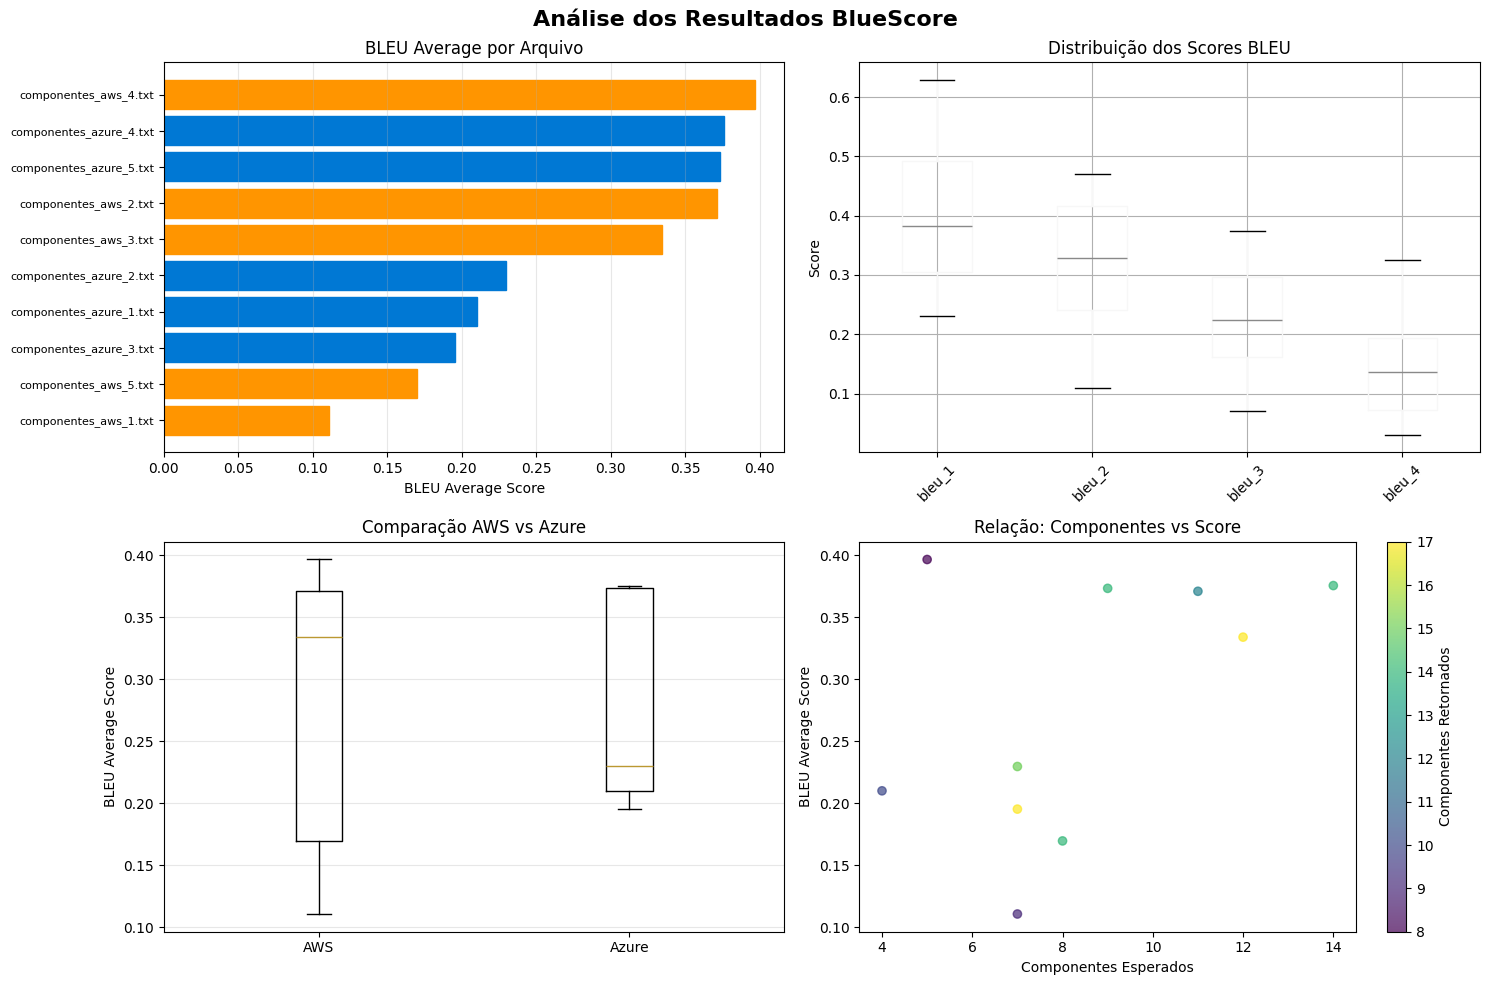


=== TABELA RESUMO FINAL ===
       componentes_esperados  componentes_retornados   bleu_1   bleu_2  \
count                 10.000                 10.0000  10.0000  10.0000   
mean                   8.400                 13.0000   0.4109   0.3232   
std                    3.134                  3.1623   0.1396   0.1223   
min                    4.000                  8.0000   0.2308   0.1102   
25%                    7.000                 10.5000   0.3042   0.2406   
50%                    7.500                 14.0000   0.3833   0.3284   
75%                   10.500                 14.7500   0.4917   0.4162   
max                   14.000                 17.0000   0.6286   0.4710   

        bleu_3   bleu_4  bleu_avg  
count  10.0000  10.0000   10.0000  
mean    0.2262   0.1461    0.2766  
std     0.0937   0.0972    0.1043  
min     0.0709   0.0309    0.1107  
25%     0.1613   0.0719    0.1990  
50%     0.2240   0.1371    0.2818  
75%     0.2958   0.1932    0.3728  
max     0.3735  

In [5]:
# Visualizações dos resultados
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo dos gráficos
plt.style.use('default')
sns.set_palette("husl")

if not df_results.empty:
    # Criar figura com subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Análise dos Resultados BlueScore', fontsize=16, fontweight='bold')
    
    # 1. Gráfico de barras com BLEU Average por arquivo
    ax1 = axes[0, 0]
    df_results_sorted = df_results.sort_values('bleu_avg', ascending=True)
    bars = ax1.barh(range(len(df_results_sorted)), df_results_sorted['bleu_avg'])
    ax1.set_yticks(range(len(df_results_sorted)))
    ax1.set_yticklabels(df_results_sorted['arquivo'], fontsize=8)
    ax1.set_xlabel('BLEU Average Score')
    ax1.set_title('BLEU Average por Arquivo')
    ax1.grid(axis='x', alpha=0.3)
    
    # Colorir barras AWS e Azure diferentemente
    for i, (bar, filename) in enumerate(zip(bars, df_results_sorted['arquivo'])):
        if 'aws' in filename.lower():
            bar.set_color('#FF9500')  # Laranja para AWS
        else:
            bar.set_color('#0078D4')  # Azul para Azure
    
    # 2. Distribuição dos scores BLEU
    ax2 = axes[0, 1]
    bleu_columns = ['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']
    df_bleu = df_results[bleu_columns]
    df_bleu.boxplot(ax=ax2)
    ax2.set_title('Distribuição dos Scores BLEU')
    ax2.set_ylabel('Score')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Comparação AWS vs Azure
    ax3 = axes[1, 0]
    if not aws_results.empty and not azure_results.empty:
        comparison_data = [
            aws_results['bleu_avg'].tolist(),
            azure_results['bleu_avg'].tolist()
        ]
        ax3.boxplot(comparison_data, labels=['AWS', 'Azure'])
        ax3.set_title('Comparação AWS vs Azure')
        ax3.set_ylabel('BLEU Average Score')
        ax3.grid(axis='y', alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Dados insuficientes\npara comparação', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Comparação AWS vs Azure')
    
    # 4. Correlação entre número de componentes e score
    ax4 = axes[1, 1]
    scatter = ax4.scatter(df_results['componentes_esperados'], 
                         df_results['bleu_avg'], 
                         c=df_results['componentes_retornados'], 
                         cmap='viridis', 
                         alpha=0.7)
    ax4.set_xlabel('Componentes Esperados')
    ax4.set_ylabel('BLEU Average Score')
    ax4.set_title('Relação: Componentes vs Score')
    plt.colorbar(scatter, ax=ax4, label='Componentes Retornados')
    
    plt.tight_layout()
    plt.show()
    
    # Tabela resumo final
    print("\n=== TABELA RESUMO FINAL ===")
    summary_stats = df_results.describe()
    print(summary_stats.round(4))
    
else:
    print("Nenhum dado disponível para visualização.")

In [6]:
# Salvar resultados em arquivo CSV
if not df_results.empty:
    output_file = "resultados_bluescore.csv"
    df_results.to_csv(output_file, index=False, encoding='utf-8')
    print(f"Resultados salvos em: {output_file}")
    
    # Criar relatório detalhado
    report_file = "relatorio_bluescore.txt"
    with open(report_file, 'w', encoding='utf-8') as f:
        f.write("=== RELATÓRIO DETALHADO DA AVALIAÇÃO BLUESCORE ===\n\n")
        f.write(f"Data da avaliação: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Número total de arquivos avaliados: {len(df_results)}\n\n")
        
        f.write("=== ESTATÍSTICAS GERAIS ===\n")
        f.write(f"BLEU-1 médio: {df_results['bleu_1'].mean():.4f} (±{df_results['bleu_1'].std():.4f})\n")
        f.write(f"BLEU-2 médio: {df_results['bleu_2'].mean():.4f} (±{df_results['bleu_2'].std():.4f})\n")
        f.write(f"BLEU-3 médio: {df_results['bleu_3'].mean():.4f} (±{df_results['bleu_3'].std():.4f})\n")
        f.write(f"BLEU-4 médio: {df_results['bleu_4'].mean():.4f} (±{df_results['bleu_4'].std():.4f})\n")
        f.write(f"BLEU Average médio: {df_results['bleu_avg'].mean():.4f} (±{df_results['bleu_avg'].std():.4f})\n\n")
        
        if not aws_results.empty:
            f.write("=== RESULTADOS AWS ===\n")
            f.write(f"Número de arquivos AWS: {len(aws_results)}\n")
            f.write(f"BLEU Average médio AWS: {aws_results['bleu_avg'].mean():.4f} (±{aws_results['bleu_avg'].std():.4f})\n")
            f.write(f"Melhor resultado AWS: {aws_results['bleu_avg'].max():.4f}\n")
            f.write(f"Pior resultado AWS: {aws_results['bleu_avg'].min():.4f}\n\n")
        
        if not azure_results.empty:
            f.write("=== RESULTADOS AZURE ===\n")
            f.write(f"Número de arquivos Azure: {len(azure_results)}\n")
            f.write(f"BLEU Average médio Azure: {azure_results['bleu_avg'].mean():.4f} (±{azure_results['bleu_avg'].std():.4f})\n")
            f.write(f"Melhor resultado Azure: {azure_results['bleu_avg'].max():.4f}\n")
            f.write(f"Pior resultado Azure: {azure_results['bleu_avg'].min():.4f}\n\n")
        
        f.write("=== RESULTADOS DETALHADOS POR ARQUIVO ===\n")
        for _, row in df_results.iterrows():
            f.write(f"\nArquivo: {row['arquivo']}\n")
            f.write(f"  Componentes esperados: {row['componentes_esperados']}\n")
            f.write(f"  Componentes retornados: {row['componentes_retornados']}\n")
            f.write(f"  BLEU-1: {row['bleu_1']:.4f}\n")
            f.write(f"  BLEU-2: {row['bleu_2']:.4f}\n")
            f.write(f"  BLEU-3: {row['bleu_3']:.4f}\n")
            f.write(f"  BLEU-4: {row['bleu_4']:.4f}\n")
            f.write(f"  BLEU Average: {row['bleu_avg']:.4f}\n")
    
    print(f"Relatório detalhado salvo em: {report_file}")
    print("\n=== AVALIAÇÃO CONCLUÍDA COM SUCESSO! ===")
    print("Arquivos gerados:")
    print(f"- {output_file}: Dados em formato CSV")
    print(f"- {report_file}: Relatório detalhado em texto")
    
else:
    print("Nenhum resultado para salvar.")

Resultados salvos em: resultados_bluescore.csv
Relatório detalhado salvo em: relatorio_bluescore.txt

=== AVALIAÇÃO CONCLUÍDA COM SUCESSO! ===
Arquivos gerados:
- resultados_bluescore.csv: Dados em formato CSV
- relatorio_bluescore.txt: Relatório detalhado em texto
